<a href="https://colab.research.google.com/github/eroj333/learning-cv-ml/blob/master/SNN/Offline%20Triplet%20Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras as k
import keras.backend as K
import numpy as np 
from keras.layers import *
from keras.models import Sequential, Model
from keras.regularizers import l2
import matplotlib.pyplot as plt
from keras.optimizers import Adam, Adadelta
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [0]:
(x_train_master, y_train_master), (x_test_master, y_test_master) = k.datasets.fashion_mnist.load_data()
x_train_master = x_train_master /  255
x_test_master = x_test_master / 255

In [0]:
x_train_master = np.expand_dims(x_train_master, 3)
x_test_master = np.expand_dims(x_test_master, 3)

In [0]:
x_train_master.shape

(60000, 28, 28, 1)

In [0]:
y_train_master = y_train_master.flatten()
y_test_master = y_test_master.flatten()

In [0]:
num_train_per_class = 1
n_epochs = 10

In [0]:
def generate_triplets(dataset, label, sample_per_class=10):
  x, y = None, None
  for i in range(10):
    pos_indices = np.argwhere(label == i)[:,0]
    neg_indices = np.argwhere(label != i)[:,0]

    # print("pos indices: {}, neg_indices: {}".format(pos_indices.shape, neg_indices.shape))
    choice_anchor = np.random.choice(pos_indices.shape[0], sample_per_class, replace=False)
    choice_anchor = pos_indices[choice_anchor]

    choice_pos = np.random.choice(pos_indices.shape[0], sample_per_class, replace=False)
    choice_pos = pos_indices[choice_pos]

    choice_neg = np.random.choice(neg_indices.shape[0], sample_per_class, replace=False)
    choice_neg = neg_indices[choice_neg]

    sub_x_anc = dataset[choice_anchor]
    
    sub_x_pos = dataset[choice_pos]

    sub_x_neg = dataset[choice_neg]
      
        
    if(x is None):
      x = [(sub_x_anc), (sub_x_pos), (sub_x_neg)]
      y = [label[choice_anchor], label[choice_pos], label[choice_neg]]
    else:
      x[0] = np.vstack((x[0], (sub_x_anc)))
      x[1] = np.vstack((x[1], (sub_x_pos)))
      x[2] = np.vstack((x[2], (sub_x_neg)))

      y[0] = np.hstack((y[0].flatten(), label[choice_anchor].flatten()))
      y[1] = np.hstack((y[1].flatten(), label[choice_pos].flatten()))
      y[2] = np.hstack((y[2].flatten(), label[choice_neg].flatten()))
    
  return x, y

In [0]:
train_x, train_y = generate_triplets(x_train_master, y_train_master)

In [0]:
train_x[0].shape

(100, 28, 28, 1)

In [0]:
def visualize_data(data, n):
  n = min(len(data[0]), n)
  random_choices = np.random.choice(len(data[0]),n, replace=False)
  fig, ax = plt.subplots(n, 3,figsize=(10,40))
  anc, pos, neg = data
  for i,ch in enumerate(random_choices):
    ax[i, 0].imshow(np.squeeze(anc[ch] ))
    ax[i, 1].imshow(np.squeeze(pos[ch] ))
    ax[i, 2].imshow(np.squeeze(neg[ch] ))
    

    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()
    ax[i, 2].set_axis_off()

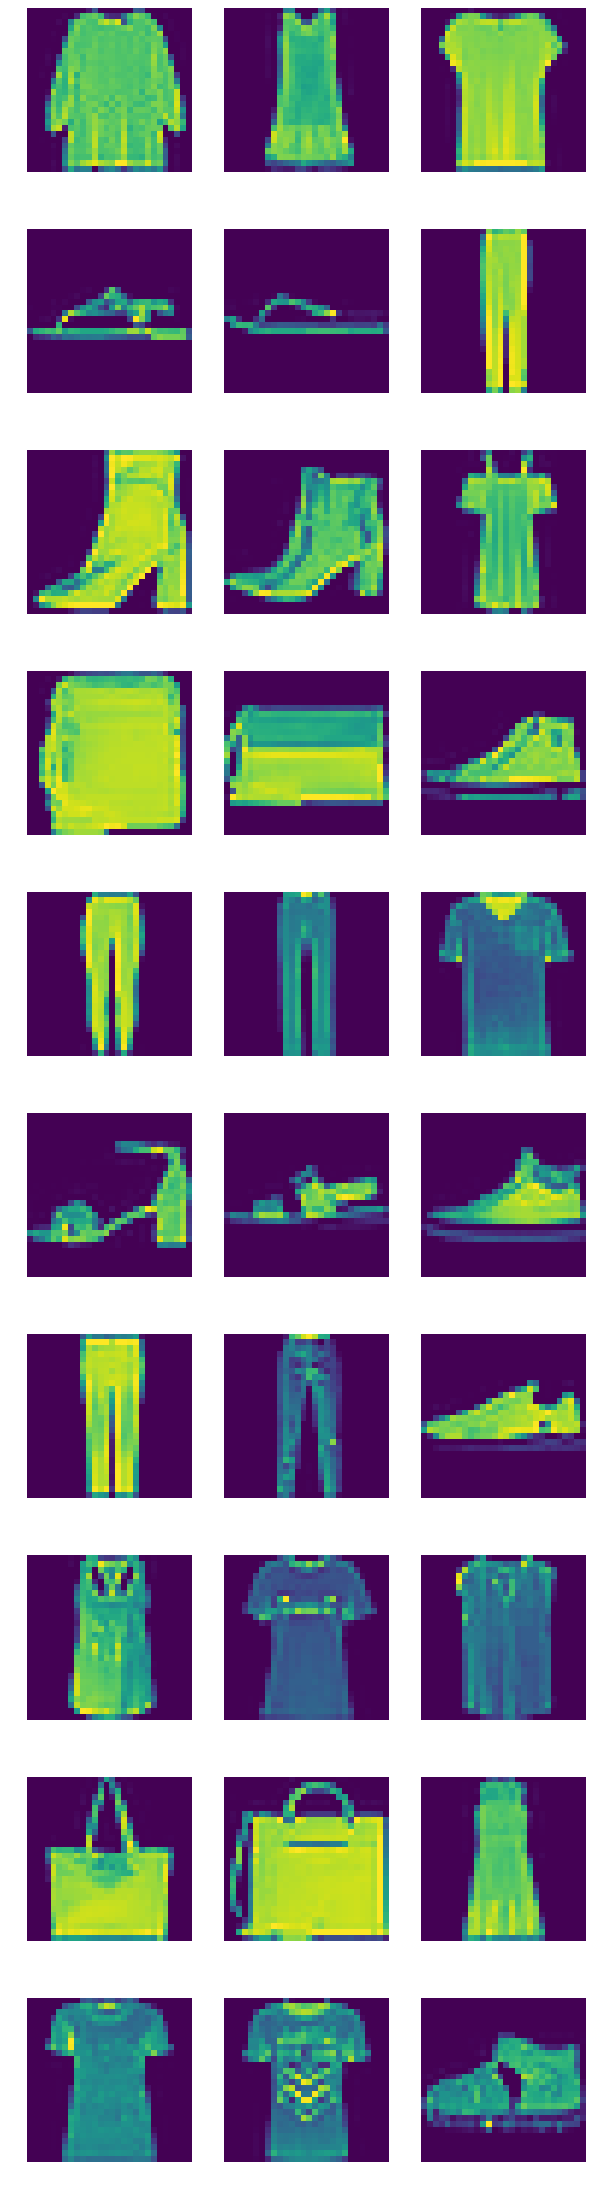

In [0]:
visualize_data(train_x, 10)

In [0]:
train_x, train_y = generate_triplets(x_train_master, y_train_master, num_train_per_class)
test_x, test_y = generate_triplets(x_test_master, y_test_master,5)

In [0]:
def triplet_loss(inputs, dist='sqeuclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    if dist == 'euclidean':
        positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = K.sum(positive_distance, axis=-1, keepdims=True)
        negative_distance = K.sum(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    if margin == 'maxplus':
        loss = K.maximum(0.0, 1 + loss)
    elif margin == 'softplus':
        loss = K.log(1 + K.exp(loss))
    return K.mean(loss)

def get_embedding_model(input_shape, embedding_dim):
    _input = Input(shape=input_shape)
    x = Flatten()(_input)
    x = Dense(embedding_dim * 4,activation="relu")(x)
    x = Dense(embedding_dim * 2, activation='relu')(x)
    x = Dense(embedding_dim)(x)
    return Model(_input, x)
        

def get_siamese_model(input_shape, triplet_margin=.3, embedding_dim=50):
    """
        Model architecture
    """
    
    # Define the tensors for the triplet of input images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input")
    
    # Convolutional Neural Network (same from earlier)
    embedding_model = get_embedding_model(input_shape, embedding_dim)
    
    # Generate the embedding outputs 
    encoded_anchor = embedding_model(anchor_input)
    encoded_positive = embedding_model(positive_input)
    encoded_negative = embedding_model(negative_input)
    
    inputs = [anchor_input, positive_input, negative_input]
    outputs = [encoded_anchor, encoded_positive, encoded_negative]
    
    # Connect the inputs with the outputs
    siamese_triplet = Model(inputs=inputs,outputs=outputs)
    
    siamese_triplet.add_loss((triplet_loss(outputs, dist='euclidean', margin='maxplus')))
    
    # return the model
    return embedding_model, siamese_triplet

# Siamese NN trained on 9 classes


In [0]:
embedding_model, siamese_triplet = get_siamese_model((28,28,1), triplet_margin=.3, embedding_dim=150)
siamese_triplet.compile(loss=None, optimizer=Adam(0.0001))

In [0]:
history = siamese_triplet.fit(x=train_x, shuffle=True, batch_size=1000,
                              validation_split=.1, epochs=n_epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 9 samples, validate on 1 samples
Epoch 1/10
9/9 [==============================] - 1s 109ms/step - loss: 0.4179 - val_loss: 3.2297
Epoch 2/10
9/9 [==============================] - 0s 1ms/step - loss: 0.2106 - val_loss: 3.1707
Epoch 3/10
9/9 [==============================] - 0s 1ms/step - loss: 0.1059 - val_loss: 3.1031
Epoch 4/10
9/9 [==============================] - 0s 1ms/step - loss: 0.0380 - val_loss: 3.0381
Epoch 5/10
9/9 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - val_loss: 2.9843
Epoch 6/10
9/9 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - val_loss: 2.9382
Epoch 7/10
9/9 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - val_loss: 2.8997
Epoch 8/10
9/9 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - val_loss: 2.8668
Epoch 9/10
9/9 [==============================] - 0s 1ms/step - loss: 0.0000

In [0]:
train_embeds = embedding_model.predict(np.vstack((train_x[0], train_x[1], train_x[2])))

In [0]:
target = np.hstack((train_y[0], train_y[1], train_y[2]))

In [0]:
from sklearn.neighbors import KNeighborsClassifier
def fit_nearest_neighbor(img_encoding, img_class, algorithm='ball_tree'):
  classifier = KNeighborsClassifier(n_neighbors=3, algorithm=algorithm)
  classifier.fit(img_encoding, img_class)
  return classifier

In [0]:
classifier = fit_nearest_neighbor(train_embeds, target)

In [0]:
e = embedding_model.predict(x_test_master)
op = classifier.predict(e)

In [0]:
# classifier.score(e, y_test_master)
# target = y_test_master.flatten()
# (np.where(target == op))[0].shape

In [0]:
(np.where(y_test_master == op))[0].shape[0] / y_test_master.shape[0]

0.4902

In [0]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test_master, op)

In [0]:
mat.diagonal()

array([602, 891, 368,  77, 473, 460, 409, 898, 436, 288])

# Classifier trained on 9 class

In [0]:
def get_classification_model(input_shape, embedding_dim):
  _inp = Input(input_shape, name="classifier_input")
  x = get_embedding_model(input_shape, embedding_dim)(_inp)
  op = Dense(10, activation='softmax')(x)

  return Model(inputs=_inp, outputs=op)

In [0]:
nn_classifier = get_classification_model((28,28,1), 150)
nn_classifier.compile(loss="categorical_crossentropy", optimizer=Adam(0.0001))

In [0]:
def generate_classifier_data(dataset, label, sample_per_class=10):
  x, y = None, None
  for i in range(10):
    pos_indices = np.argwhere(label == i)[:,0]

    # print("pos indices: {}, neg_indices: {}".format(pos_indices.shape, neg_indices.shape))
    choice_anchor = np.random.choice(pos_indices.shape[0], sample_per_class, replace=False)
    choice_anchor = pos_indices[choice_anchor]

    sub_x_anc = dataset[choice_anchor]
    
        
    if(x is None):
      x = sub_x_anc
      y = label[choice_anchor]
    else:
      x = np.vstack((x, (sub_x_anc)))

      y = np.hstack((y.flatten(), label[choice_anchor].flatten()))
    
  return x, y

In [0]:
classifier_train_x, classifier_train_y = generate_classifier_data(x_train_master, y_train_master, num_train_per_class)
classifier_test_x, classifier_test_y = generate_classifier_data(x_test_master, y_test_master, 5)

In [0]:
history = nn_classifier.fit(x=classifier_train_x, y=k.utils.to_categorical(classifier_train_y), shuffle=True, batch_size=1000,
                              validation_split=.1, epochs=n_epochs)

Train on 9 samples, validate on 1 samples
Epoch 1/10
9/9 [==============================] - 0s 39ms/step - loss: 2.3229 - val_loss: 2.7871
Epoch 2/10
9/9 [==============================] - 0s 1ms/step - loss: 2.1392 - val_loss: 2.8996
Epoch 3/10
9/9 [==============================] - 0s 1ms/step - loss: 1.9787 - val_loss: 3.0173
Epoch 4/10
9/9 [==============================] - 0s 1ms/step - loss: 1.8354 - val_loss: 3.1359
Epoch 5/10
9/9 [==============================] - 0s 966us/step - loss: 1.7079 - val_loss: 3.2495
Epoch 6/10
9/9 [==============================] - 0s 937us/step - loss: 1.5956 - val_loss: 3.3562
Epoch 7/10
9/9 [==============================] - 0s 881us/step - loss: 1.4910 - val_loss: 3.4643
Epoch 8/10
9/9 [==============================] - 0s 1ms/step - loss: 1.3924 - val_loss: 3.5711
Epoch 9/10
9/9 [==============================] - 0s 1ms/step - loss: 1.3018 - val_loss: 3.6675
Epoch 10/10
9/9 [==============================] - 0s 1ms/step - loss: 1.2171 - val_los

In [0]:
op = nn_classifier.predict(x_test_master)

In [0]:
pred = np.argmax(op, axis=1)
pred

array([8, 4, 3, ..., 6, 0, 0])

In [0]:
(np.where(y_test_master == pred))[0].shape[0] / y_test_master.shape[0]

0.2713

In [0]:
mat = confusion_matrix(y_test_master, pred)
mat.diagonal()

array([ 51, 119, 232, 532, 392, 196, 636, 369, 186,   0])

# Baseline NN on all classes

In [0]:
### Data shuffle for training 
def shuffle_classifier_data(inputs, labels):
  randomizer = np.random.choice(inputs.shape[0], inputs.shape[0], replace=False)
  x = inputs[randomizer]
  y = labels[randomizer]
  return x, y

In [0]:
classifier_train_x, classifier_train_y = shuffle_classifier_data(classifier_train_x, classifier_train_y)

In [0]:
nn_classifier2 = get_classification_model((28,28,1), 150)
nn_classifier2.compile(loss="categorical_crossentropy", optimizer=Adam(0.0001))

In [0]:
history = nn_classifier2.fit(x=classifier_train_x, y=k.utils.to_categorical(classifier_train_y), shuffle=True, batch_size=1000,
                              validation_split=.1, epochs=n_epochs)

Train on 9 samples, validate on 1 samples
Epoch 1/10
9/9 [==============================] - 0s 51ms/step - loss: 2.5757 - val_loss: 2.5053
Epoch 2/10
9/9 [==============================] - 0s 1ms/step - loss: 2.3668 - val_loss: 2.5510
Epoch 3/10
9/9 [==============================] - 0s 1ms/step - loss: 2.1775 - val_loss: 2.6021
Epoch 4/10
9/9 [==============================] - 0s 1ms/step - loss: 2.0059 - val_loss: 2.6572
Epoch 5/10
9/9 [==============================] - 0s 1ms/step - loss: 1.8542 - val_loss: 2.7194
Epoch 6/10
9/9 [==============================] - 0s 1ms/step - loss: 1.7204 - val_loss: 2.7847
Epoch 7/10
9/9 [==============================] - 0s 1ms/step - loss: 1.6028 - val_loss: 2.8628
Epoch 8/10
9/9 [==============================] - 0s 1ms/step - loss: 1.4969 - val_loss: 2.9442
Epoch 9/10
9/9 [==============================] - 0s 1ms/step - loss: 1.4006 - val_loss: 3.0256
Epoch 10/10
9/9 [==============================] - 0s 1ms/step - loss: 1.3119 - val_loss: 3.1

In [0]:
op2 = nn_classifier2.predict(x_test_master)
pred2 = np.argmax(op2, axis=1)
(np.where(y_test_master == pred2))[0].shape[0] / y_test_master.shape[0]

0.3494

In [0]:
mat = confusion_matrix(y_test_master, pred2)
mat.diagonal()

array([  0, 576, 330, 443, 803,  35, 176, 236,  24, 871])

# Siamese NN trained on all classes

In [0]:
def shuffle_triplets(inputs, labels):
  a, p, n = inputs
  l1, l2, l3 = labels
  randomizer = np.random.choice(a.shape[0], a.shape[0], replace=False)
  a = a[randomizer]
  p = p[randomizer]
  n = n[randomizer]

  l1 = l1[randomizer]
  l2 = l2[randomizer]
  l3 = l3[randomizer]
  return [a, p, n], [l1,l2,l3]

In [0]:
train_x, train_y = shuffle_triplets(train_x, train_y)

In [0]:
embedding_model2, siamese_triplet2 = get_siamese_model((28,28,1), triplet_margin=.3, embedding_dim=150)
siamese_triplet2.compile(loss=None, optimizer=Adam(0.0001))
history_s2 = siamese_triplet2.fit(x=train_x, shuffle=True, batch_size=1000,
                              validation_split=.1, epochs=n_epochs)

Train on 9 samples, validate on 1 samples
Epoch 1/10
9/9 [==============================] - 0s 49ms/step - loss: 0.6772 - val_loss: 0.9643
Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.4646 - val_loss: 0.9030
Epoch 3/10
9/9 [==============================] - 0s 1ms/step - loss: 0.3126 - val_loss: 0.8500
Epoch 4/10
9/9 [==============================] - 0s 1ms/step - loss: 0.1686 - val_loss: 0.7989
Epoch 5/10
9/9 [==============================] - 0s 1ms/step - loss: 0.0558 - val_loss: 0.7449
Epoch 6/10
9/9 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - val_loss: 0.6950
Epoch 7/10
9/9 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - val_loss: 0.6469
Epoch 8/10
9/9 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - val_loss: 0.6039
Epoch 9/10
9/9 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - val_loss: 0.5659
Epoch 10/10
9/9 [==============================] - 0s 1ms/step - loss: 0.0000

In [0]:
train_embeds = embedding_model2.predict(np.vstack((train_x[0], train_x[1], train_x[2])))

In [0]:
target = np.hstack((train_y[0], train_y[1], train_y[2]))

In [0]:
from sklearn.neighbors import KNeighborsClassifier
def fit_nearest_neighbor(img_encoding, img_class, algorithm='ball_tree'):
  classifier = KNeighborsClassifier(n_neighbors=3, algorithm=algorithm)
  classifier.fit(img_encoding, img_class)
  return classifier

In [0]:
classifier2 = fit_nearest_neighbor(train_embeds, target)

In [0]:
e2 = embedding_model2.predict(x_test_master)
op2 = classifier2.predict(e2)

In [0]:
# classifier.score(e, y_test_master)
# target = y_test_master.flatten()
# (np.where(target == op))[0].shape

In [0]:
(np.where(y_test_master == op2))[0].shape[0] / y_test_master.shape[0]

0.5184

In [0]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test_master, op2)

In [0]:
mat.diagonal()

array([588, 868, 295, 148, 431, 357, 425, 695, 530, 847])

Training Examples per class | Siamese Accuracy (9 classes) | Baseline NN (9 classes) accuracy | Baseline NN - all classes | Siamese NN - all classes | Epochs  
--- | --- | --- | --- | --- | ---
500| 0.8133          | 0.743  | 0.8346 | 0.8121 |  40 
300| 0.8096           | 0.7335  | 0.8128 | 0.805 | 40 
200 | 0.7986 | 0.7154 | 0.7919   |0.7999  | 40 
50 | 0.7566 | 0.6713 | 0.7265 | 0.7541 | 40 
5 | 0.6503 | 0.5607 |0.6202 | 0.6474 | 40 
1 | 0.4782 | 0.4545 |0.5084 | 0.52 | 40 
1 | 0.4902 | 0.2713 |0.3494 | 0.5184 | 10 


